In [1]:
# Imports
import numpy as np
import csv
from collections import Counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Load data

In [2]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

In [3]:
# Native country: US and not US
X_train['native-country'][X_train['native-country'] != "United-States"] = "Non-United-States"
X_test['native-country'][X_test['native-country'] != "United-States"] = "Non-United-States"

# One-hot-encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print(X_train.shape)
print(X_test.shape)

(24421, 62)
(24421, 62)


/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [4]:
## Create a parameter grid for gridsearch

# Number of trees in random forest
n_estimators = [100, 500, 1000, 5000, 10000]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [3, 5, 10, 25, 50, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 500, 1000, 5000, 10000], 'max_features': ['auto', None], 'max_depth': [3, 5, 10, 25, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [5]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
rf_gridsearch = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                   scoring="f1_weighted", n_iter=2000, cv=3, verbose=6, n_jobs=8, random_state=42)
# Fit the random searfch model
rf_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
rf_gridsearch.best_params_

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1080 is smaller than n_iter=2000. Running 1080 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 24.8min
[Parallel(n_jobs=8)]: Done 297 tasks      | elapsed: 55.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 80.0min
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 597 tas

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [6]:
## Evaluate improvment between the base model and the fine-tuned model

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_model = rf_gridsearch.best_estimator_
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.780, total=   2.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .................................... , score=0.808, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] .................................... , score=0.780, total=   2.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s


[CV] .................................... , score=0.786, total=   3.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.2s remaining:    0.0s


[CV] .................................... , score=0.778, total=   2.7s
0.7865223508761439 0.011084921671558372
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.799, total=  21.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV] .................................... , score=0.816, total=  21.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.4s remaining:    0.0s


[CV] .................................... , score=0.794, total=  20.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV] .................................... , score=0.803, total=  23.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV] .................................... , score=0.790, total=  20.4s
0.8005646960822285 0.008808830500477056
Improvement of 1.79%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


# Train on whole dataset using optimised set of parameters

In [7]:
final_model = RandomForestClassifier(**rf_gridsearch.best_params_, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Predict on test and save

,prediction
id,
1,0
2,0
3,0
4,0
5,0


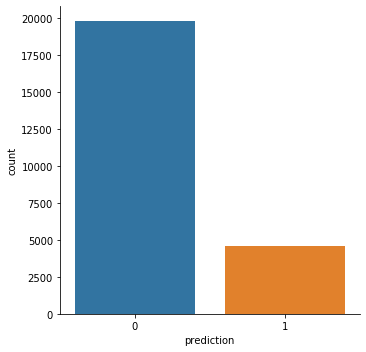

In [12]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index.name = 'id'
df.index += 1
sns.catplot(x="prediction", kind="count", data=df)
df.head()

In [11]:
# experience name
experience = 'RF_onehot_usVSnonuscountry'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))